## Gravitational wave Astrometry estimates for an isolated CW source

This notebook build on the `MetricsNotebook` to compute an estimate for the precision with which the sky location of an isolated monochromatic gravitatioal wave source can be measured with a specific space-based GW mission concept. 

To run this on Google Colab:
markdown
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnGBaker/GWI-metrics/blob/main/Notebooks/CWSNRNotebook.ipynb)

### Some basic setup

In [1]:
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/JohnGBaker/GWI-metrics.git
    src='GWI-metrics/src/'
else:
    src='../src/'
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append(src)
import metrics
import concepts
import constants

### Define the mission concept
We use a dictionary to collect the basic relevant mission parameters.  For now we just have a few basic params an LISA as a reference case.

For the LISASciRDv1 example we provide explicit values for the core noise levels. We have allowed for providing a function which derives these based on lower-level parameters as well.
Some parameters:

| Name         | Units             | Description |
| :- | :- | :- |
| sqSacc_level | $m/s^2/\sqrt{Hz}$ | Acceleration noise level     |
| sqSacc_func  | --                | Function to compute acceleration noise level     |
| sqSoms_level | $m/\sqrt{Hz}$     | Optical metrology system noise level     |
| sqSoms_func  | --                | Function to compute optical metrology system noise level     |
| Lconst       | $m$               | Constellation armlength scale |
| Rorbit       | AU                | Size of orbit |
| Torbit       | yr                | Period of orbit |
| Dsep         | AU                | Distance separating multiple constellations |
| Nindep       | --                | Number of independent GW channels  |

In [2]:
# here we load in a pre-defined option
LISASciRDv1=concepts.LISASciRDv1
LISASciRDv1

{'label': 'LISA(SciRDv1)',
 'sqSacc_level': 3e-15,
 'sqSoms_level': 1.5e-11,
 'Lconst': 2500000000.0,
 'Dsep': 0,
 'Rorbit': 1.0,
 'Torbit': 1.0,
 'Nindep': 2}

### Define the source
Again, we make use of a dicitonary to collect parameters.  The idea is that the definition can be flexible for different parametrizations of source types. Here are the potential parmetrizations for a CW source

| Name         | Units             | Description |
| :- | :- | :- |
| f0 | Hz | GW frequency (overrides semimajor axis if both are provided)     |
| h0 | --                | GW amplitude (overrides other parameters if provided)   |
| m1 | $M_{Sun}$     | component mass 1  |
| m2 | $M_{Sun}$     | component mass 2  |
| mtot | $M_{Sun}$   | total mass (together with mchirp, overrides m1 and m2)  |
| mchirp | $M_{Sun}$   | chirp mass (together with mtot, overrides m1 and m2)  |
| dl | $kpc$   | luminosity distance |
| a  | AU   | semi-major axis     |
| T  | s   | observation time. if an array is provided, SNR functions return SNR vs. time |


In [3]:
# Parameters for AmCV taken from CLHT demo
AmCV = {
    'type' : 'CW',
    'label' : 'AmCV',
    'm1' : 0.68,
    'm2' : 0.125,
    'dl' : 0.3,
    'a'  : 0.5*9.5e-4,
    'T'  : 3.1e7
}

### SNR calculations


In [4]:
# first we do a single point estimate
snr,AmCV = metrics.getSourceSnr(AmCV,LISASciRDv1)
print('SNR = %4.1f' % snr)

SNR = 690.6


Text(0, 0.5, 'SNR')

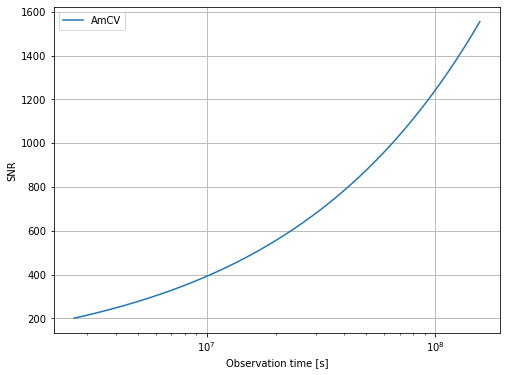

In [5]:
# SNR as a function of time
t = np.logspace(np.log10((1/12)*np.pi*1e7),np.log10(5*np.pi*1e7),100)
source = AmCV.copy()
source['T'] = t
snrt, source = metrics.getSourceSnr(source,LISASciRDv1)

plt.figure(figsize=[8,6])
plt.plot(t,snrt,label=AmCV.get('label'))
plt.legend()
plt.xscale('log')
plt.grid(True)
plt.xlabel('Observation time [s]')
plt.ylabel('SNR')


### Angular resolution

First we estimate the diffraction-liied angular resolution as a function of observation time from

$\delta\theta \approx \lambda_{GW}/B$

where $\lambda_{GW} = c/f_{GW}$ is the GW frequency and B is the observation baseline

for a ciruclar orbit:

$B=R_{orbit}\sqrt{2(1-cos[2\pi t/T_{orbit}])}$


Text(0, 0.5, 'Diffraction limit [rad]')

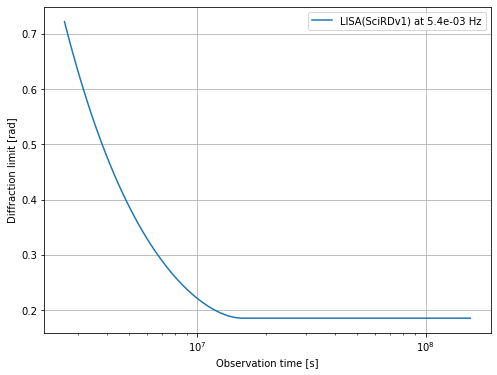

In [6]:
# Estimate diffraction limit as a function of time
lamGW = constants.c / source.get('f0')
t = source.get('T')
theta = 2*np.pi*np.clip(t/(LISASciRDv1.get('Torbit')*constants.year),0,0.5)
B = LISASciRDv1.get('Rorbit')*constants.AU*np.sqrt(2*(1-np.cos(theta)))
deltaThetaDiff = (lamGW/constants.c)/B
plt.figure(figsize=[8,6])
plt.plot(t,deltaThetaDiff,label='%s at %2.1e Hz' % (LISASciRDv1.get('label'), source.get('f0')))
plt.legend()
plt.xscale('log')
plt.grid(True)
plt.xlabel('Observation time [s]')
plt.ylabel('Diffraction limit [rad]')

Text(0, 0.5, 'Astrometric Precision [mrad]')

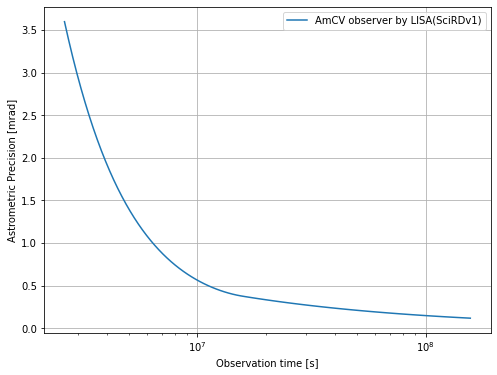

In [7]:
# Angular resolution
deltaTheta = deltaThetaDiff/snrt
plt.figure(figsize=[8,6])
plt.plot(t,deltaTheta*1e3,label='%s observer by %s' % (source.get('label'), LISASciRDv1.get('label')))
plt.legend()
plt.xscale('log')
plt.grid(True)
plt.xlabel('Observation time [s]')
plt.ylabel('Astrometric Precision [mrad]')

### Compare angular resolution of two concepts


In [8]:
concepts = [concepts.LISASciRDv1, concepts.LISAGrande]

Text(0, 0.5, 'SNR')

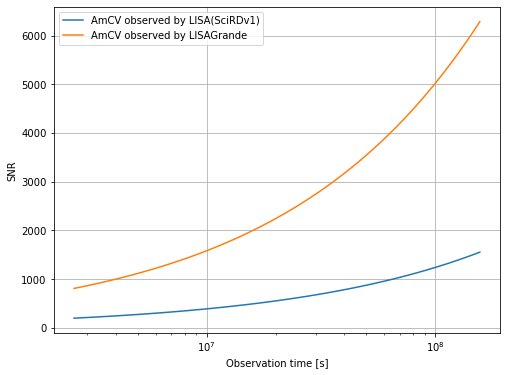

In [9]:
# SNR as a function of time
t = np.logspace(np.log10((1/12)*np.pi*1e7),np.log10(5*np.pi*1e7),100)
source = AmCV.copy()
source['T'] = t
snrt = np.zeros([len(t),len(concepts)])

plt.figure(figsize=[8,6])

for idx,c in enumerate(concepts):
    snrt[:,idx], source = metrics.getSourceSnr(source,c)
    plt.plot(t,snrt[:,idx],label='%s observed by %s' % (source.get('label'),c.get('label')))

plt.legend()
plt.xscale('log')
plt.grid(True)
plt.xlabel('Observation time [s]')
plt.ylabel('SNR')


Text(0, 0.5, 'Diffraction limit [rad]')

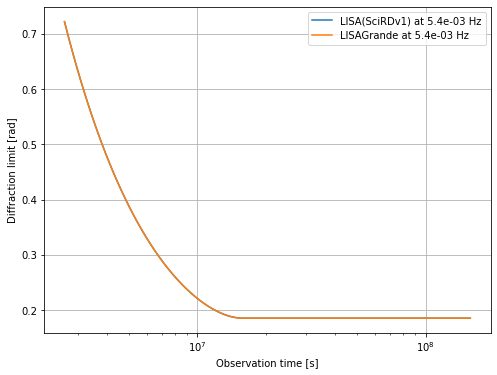

In [10]:
# diffraction limit
lamGW = constants.c / source.get('f0')
t = source.get('T')
deltaThetaDiff = np.zeros([len(t),len(concepts)])

plt.figure(figsize=[8,6])

for idx,c in enumerate(concepts):
    theta = 2*np.pi*np.clip(t/(c.get('Torbit')*constants.year),0,0.5)
    B = c.get('Rorbit')*constants.AU*np.sqrt(2*(1-np.cos(theta)))
    deltaThetaDiff[:,idx] = (lamGW/constants.c)/B

    plt.plot(t,deltaThetaDiff[:,idx],label='%s at %2.1e Hz' % (c.get('label'), source.get('f0')))
plt.legend()
plt.xscale('log')
plt.grid(True)
plt.xlabel('Observation time [s]')
plt.ylabel('Diffraction limit [rad]')

Text(0, 0.5, 'Astrometric Precision [mrad]')

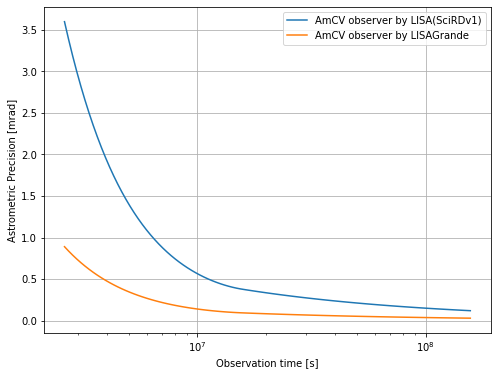

In [11]:
# Angular resolution
deltaTheta = deltaThetaDiff/snrt
plt.figure(figsize=[8,6])

for idx,c in enumerate(concepts):
    plt.plot(t,deltaTheta[:,idx]*1e3,label='%s observer by %s' % (source.get('label'), c.get('label')))

plt.legend()
plt.xscale('log')
plt.grid(True)
plt.xlabel('Observation time [s]')
plt.ylabel('Astrometric Precision [mrad]')